# **STEP 17.1:** Machine Learning Model #1 - XGBoost

In [1]:
#!pip install --upgrade scikit-learn
#!pip install --upgrade xgboost

In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

Só vamos utilizar o excel final do tratamento, uma vez que contém os dados iniciais do doente/metástase 
antes de um segundo tratamento e serve apenas para prever recorrência futura. (só quando quisermos usar 
outros exames para monitorização e previsão após o primeiro tratamento é que se utiliza imagens follow-up)

### Isodose + ROI - Delta Radiomics + Clinical Features

In [2]:
absolute_data_isodose_roi = pd.read_csv("/notebooks/disk2/CSV_Dataset/07_RF_Treatment_Clinical.csv")

absolute_data_isodose_roi["Decision"] = (
    absolute_data_isodose_roi["Decision"]
    .replace({"2nd Treatment": 1})
)

absolute_data_isodose_roi["Decision"] = (
    absolute_data_isodose_roi["Decision"]
    .replace({"Follow-up": 0})
)

X = absolute_data_isodose_roi.drop(columns=['Patient ID', 'Mask Name','Decision', 'First Treatment', 'First Follow-Up'])
y = absolute_data_isodose_roi["Decision"]

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("-------")
print(X.shape)
print(y.value_counts())
print("-------")

preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)],
    remainder="passthrough"
)


X_encoded = preprocessor.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print("-------")
print(f"Training set: {x_train.shape}, Test set: {x_test.shape}\n")
print(f"Train Distribution:\n{pd.value_counts(y_train)}\n")
print(f"Test Distribution:\n{pd.value_counts(y_test)}")
print("-------")

-------
(177, 1326)
Decision
1    132
0     45
Name: count, dtype: int64
-------
-------
Training set: (141, 1339), Test set: (36, 1339)

Train Distribution:
Decision
1    105
0     36
Name: count, dtype: int64

Test Distribution:
Decision
1    27
0     9
Name: count, dtype: int64
-------


### Define best parameters of XGBoost

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.9, 'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.9}
Best CV Score (F1): 0.957862950058072
Train accuracy: 1.0
Classification Report (Train):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00       105

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141

Confusion Matrix (Train):
 [[ 36   0]
 [  0 105]]


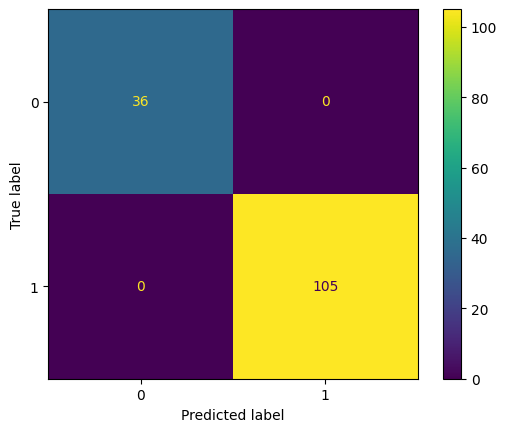

In [9]:
param_dist = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [3, 4, 5, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.1, 0.3, 0.5, 1.0],
    "reg_alpha": [0, 0.01, 0.1, 1.0],
    "reg_lambda": [0, 0.01, 0.1, 1.0],
}

pos = int(np.sum(y_train))
neg = int(len(y_train) - pos)
scale_pos_weight = neg / pos if pos > 0 else 1.0

xgb_clf = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=1,
    tree_method="hist",         
    scale_pos_weight=scale_pos_weight
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=100,                 
    scoring="f1",               
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    refit=True                  
)

random_search.fit(x_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best CV Score (F1):", random_search.best_score_)
best_params = random_search.best_params_
best_xgb = random_search.best_estimator_

y_pred_tr = best_xgb.predict(x_train)
print("Train accuracy:", accuracy_score(y_train, y_pred_tr))
print("Classification Report (Train):\n", classification_report(y_train, y_pred_tr))
print("Confusion Matrix (Train):\n", confusion_matrix(y_train, y_pred_tr))

ConfusionMatrixDisplay.from_estimator(best_xgb, x_train, y_train)
plt.show()

Test accuracy: 0.9444444444444444
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.96      0.96      0.96        27

    accuracy                           0.94        36
   macro avg       0.93      0.93      0.93        36
weighted avg       0.94      0.94      0.94        36

Confusion Matrix (Test):
 [[ 8  1]
 [ 1 26]]


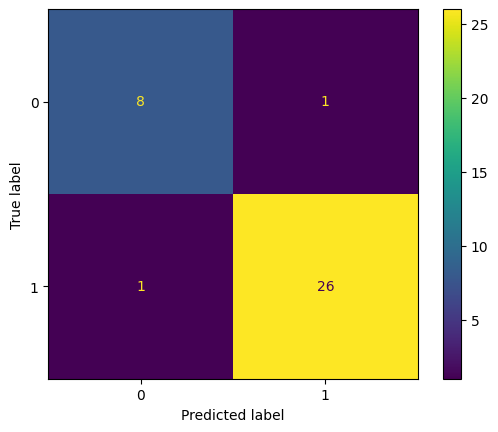

In [6]:
y_pred_te = best_xgb.predict(x_test)
print("Test accuracy:", accuracy_score(y_test, y_pred_te))
print("Classification Report (Test):\n", classification_report(y_test, y_pred_te))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_pred_te))
ConfusionMatrixDisplay.from_estimator(best_xgb, x_test, y_test)
plt.show()

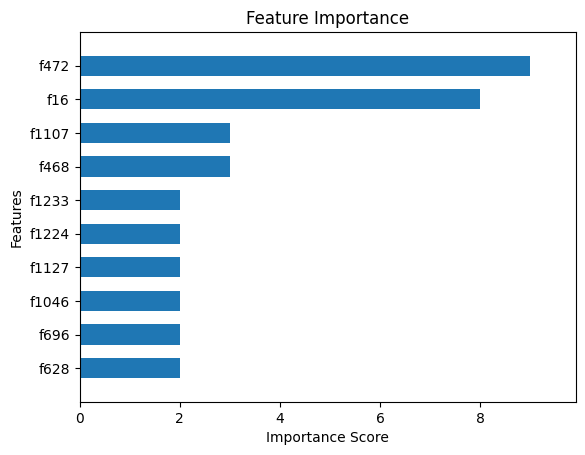

In [8]:
# Plot the importance of features
plot_importance(best_xgb, max_num_features=10, show_values=False, importance_type='weight', height=0.6, grid=False)
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.show()